In [1]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.models as models

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# Obtaining pretrained weights for ViT-Base model
pretrained_weights = models.ViT_B_16_Weights.DEFAULT 

# Instantiating a ViT model with the pretrained weights
pretrained = models.vit_b_16(weights=pretrained_weights).to(device)

# Freezing the parameters of the base model to prevent them from being updated during training
for parameter in pretrained.parameters():
    parameter.requires_grad = False
    
# Modifying the classifier head for the specific classification task
class_names = ['cataract','diabetic_retinopathy','glaucoma','normal']

# Setting random seeds for reproducibility
set_seeds()

# Replacing the classifier head with a new linear layer
pretrained.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [6]:
pip install torchinfo


Note: you may need to restart the kernel to use updated packages.


In [7]:
from torchinfo import summary

# Generating a summary using torchinfo (uncommented to display actual output)
summary(model=pretrained, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 4]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [8]:
# Defining directory paths for training and testing images
training_dir = '/Users/krishnaprithvibattula/Documents/AI/ImageClassificationUsingVisionTransformer/Training'
testing_dir = '/Users/krishnaprithvibattula/Documents/AI/ImageClassificationUsingVisionTransformer/Testing'

In [9]:
# Obtaining automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [10]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    training_dir: str, 
    testing_dir: str, 
    transforms: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Creating dataset(s) from ImageFolder for training and testing
  train_data = datasets.ImageFolder(training_dir, transform=transforms)
  test_data = datasets.ImageFolder(testing_dir, transform=transforms)

  # Extracting class names from the training dataset
  class_names = train_data.classes

  # Creating DataLoader objects for training and testing dataset(s)
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=0,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=0,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [11]:
# Setting up dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(training_dir=training_dir,
                                                                                                     testing_dir=testing_dir,
                                                                                                     transforms=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [12]:
from goingmodular.going_modular import engine

# Defining the optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Training the classification head of the pre-trained ViT feature extraction model
set_seeds() # Setting random seeds for reproducibility
pretrained_vit_results = engine.train(model=pretrained,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=15,
                                      device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6603 | train_acc: 0.7427 | test_loss: 0.5400 | test_acc: 0.7821
Epoch: 2 | train_loss: 0.4837 | train_acc: 0.8205 | test_loss: 0.4409 | test_acc: 0.8325
Epoch: 3 | train_loss: 0.4263 | train_acc: 0.8452 | test_loss: 0.3904 | test_acc: 0.8725
Epoch: 4 | train_loss: 0.3965 | train_acc: 0.8584 | test_loss: 0.3738 | test_acc: 0.8690
Epoch: 5 | train_loss: 0.3700 | train_acc: 0.8680 | test_loss: 0.3448 | test_acc: 0.8892
Epoch: 6 | train_loss: 0.3543 | train_acc: 0.8763 | test_loss: 0.3674 | test_acc: 0.8638
Epoch: 7 | train_loss: 0.3376 | train_acc: 0.8813 | test_loss: 0.3405 | test_acc: 0.8752
Epoch: 8 | train_loss: 0.3199 | train_acc: 0.8896 | test_loss: 0.3176 | test_acc: 0.8975
Epoch: 9 | train_loss: 0.3074 | train_acc: 0.8965 | test_loss: 0.2963 | test_acc: 0.9104
Epoch: 10 | train_loss: 0.2982 | train_acc: 0.8997 | test_loss: 0.2776 | test_acc: 0.9090
Epoch: 11 | train_loss: 0.2957 | train_acc: 0.9012 | test_loss: 0.3141 | test_acc: 0.8783
Epoch: 12 | train_l

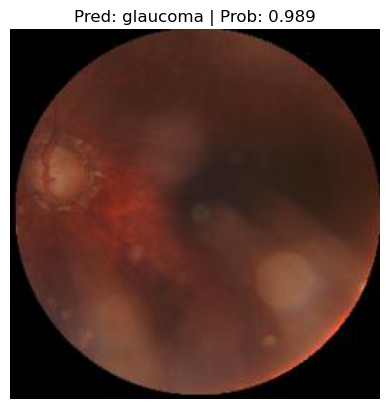

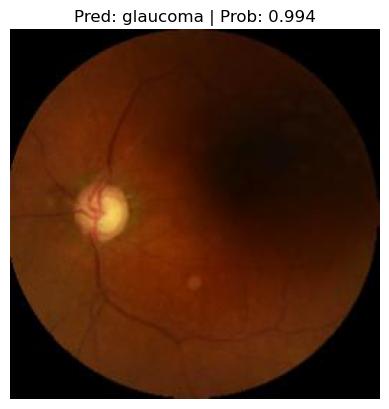

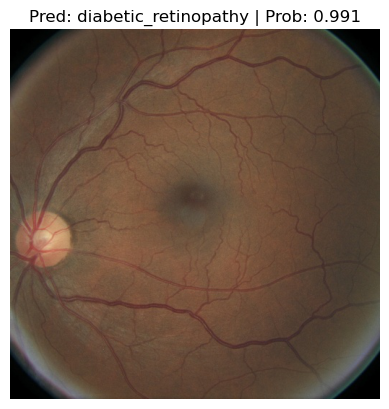

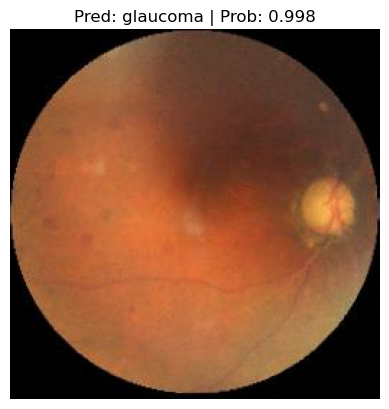

In [16]:
# Importing function for image prediction and plotting from the modular module
from goingmodular.going_modular.predictions import pred_and_plot_image

# Defining custom image paths for prediction
custom_image_path = ["/Users/krishnaprithvibattula/Documents/AI/ImageClassificationUsingVisionTransformer/Testing/glaucoma/_8_5210275.jpg",
                     "/Users/krishnaprithvibattula/Documents/AI/ImageClassificationUsingVisionTransformer/Testing/glaucoma/_180_6449017.jpg",
                     "/Users/krishnaprithvibattula/Documents/AI/ImageClassificationUsingVisionTransformer/Testing/diabetic_retinopathy/1024_right.jpeg",
                     "/Users/krishnaprithvibattula/Documents/AI/ImageClassificationUsingVisionTransformer/Testing/glaucoma/_269_7481383.jpg"]

# Predicting and plotting each image
for image in custom_image_path:
    pred_and_plot_image(model=pretrained,
                    image_path=image,
                    class_names=class_names)

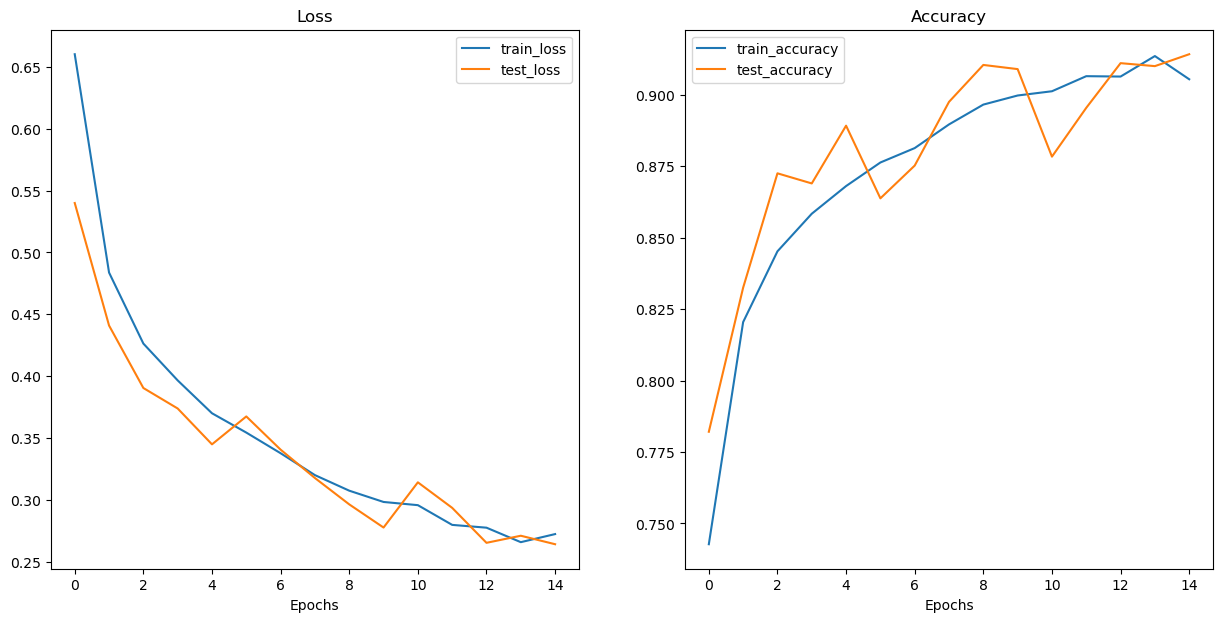

In [14]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)